In [11]:
%cd /content/drive/MyDrive/brain tumor detection/Brain-Tumor-Detection-master

/content/drive/MyDrive/brain tumor detection/Brain-Tumor-Detection-master


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**IMPORT NECESSARY MODULES**

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

**Data Preparation & Preprocessing**

In [9]:
def crop_brain_contour(image, plot=False):
    
   
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

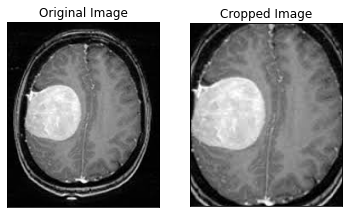

In [12]:
ex_img = cv2.imread('yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

Load up the data

In [13]:
def load_data(dir_list, image_size):
   

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '/' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [14]:
augmented_path = 'augmented data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


Plot sample images:

In [15]:
def plot_sample_images(X, y, n=50):
    
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

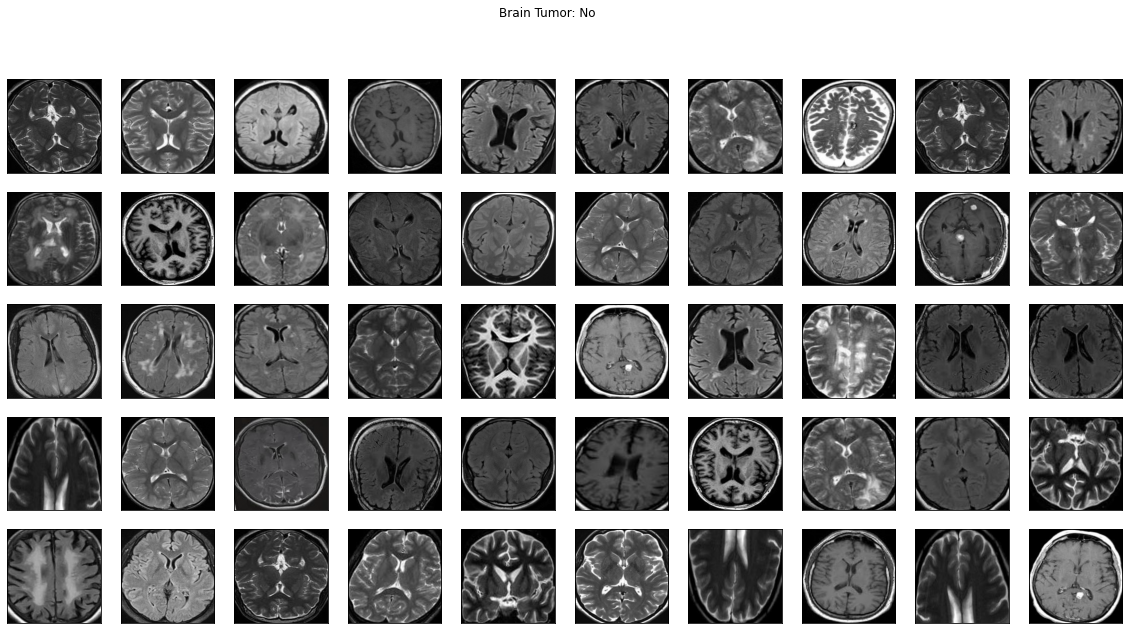

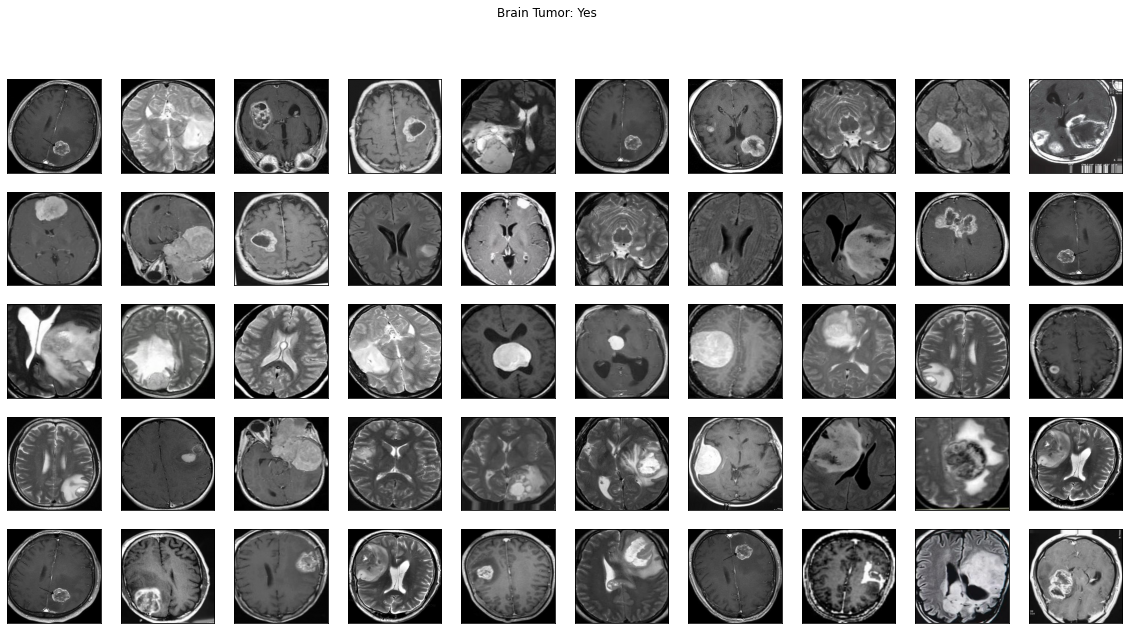

In [16]:
plot_sample_images(X, y)

**Split the data:**

Split X and y into training, validation  and test sets.


In [17]:
def split_data(X, y, test_size=0.2):
       
   
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

Let's use the following way to split:

    70% of the data for training.
    15% of the data for validation.
    15% of the data for testing.



In [18]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [19]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1445
number of development examples = 310
number of test examples = 310
X_train shape: (1445, 240, 240, 3)
Y_train shape: (1445, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310, 1)


Helper functions

In [20]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [14]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

**Build the model**

Let's build a convolutional neural network model:


In [21]:
def build_model(input_shape):
   
   
    X_input = Input(input_shape) 
    
    
    X = ZeroPadding2D((2, 2))(X_input) 
    
    
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)
    
   
    X = MaxPooling2D((4, 4), name='max_pool0')(X) 
    
   
    X = MaxPooling2D((4, 4), name='max_pool1')(X) 
    
   
    X = Flatten()(X) 
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates  Keras model instance, use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

Define the image shape:

In [22]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [23]:
model = build_model(IMG_SHAPE)

In [24]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 244, 244, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 238, 238, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 238, 238, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 238, 238, 32)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 59, 59, 32)        0         
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 14, 14, 32)

Compile the model:

In [25]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [28]:
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

Train the model

In [29]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
46/46 [==============================] - 116s 3s/step - loss: 1.2359 - accuracy: 0.5525 - val_loss: 0.6513 - val_accuracy: 0.6452
INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-01-0.65.model/assets
Epoch 2/10
46/46 [==============================] - 120s 3s/step - loss: 0.5025 - accuracy: 0.7501 - val_loss: 0.6048 - val_accuracy: 0.7323
INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-02-0.73.model/assets
Epoch 3/10
46/46 [==============================] - 118s 3s/step - loss: 0.4295 - accuracy: 0.8026 - val_loss: 0.6063 - val_accuracy: 0.6645
INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-03-0.66.model/assets
Epoch 4/10
46/46 [==============================] - 116s 3s/step - loss: 0.3900 - accuracy: 0.8217 - val_loss: 0.7879 - val_accuracy: 0.4968
INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-04-0.50.model/assets
Epoch 5/10
46/46 [==============================] - 116s 3s/step - loss: 0.3

In [30]:
history = model.history.history

In [31]:
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


Plot Loss & Accuracy

In [32]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

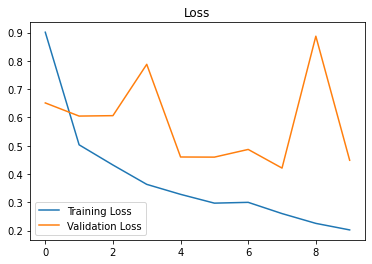

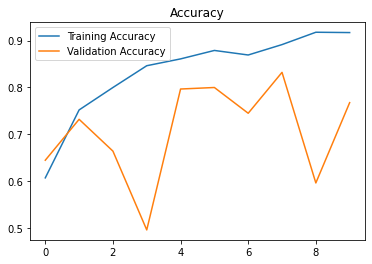

In [33]:
plot_metrics(history) 

In [34]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/5
46/46 [==============================] - 117s 3s/step - loss: 0.2959 - accuracy: 0.8740 - val_loss: 0.5635 - val_accuracy: 0.7516
INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-01-0.75.model/assets
Epoch 2/5
46/46 [==============================] - 116s 3s/step - loss: 0.1916 - accuracy: 0.9246 - val_loss: 0.2994 - val_accuracy: 0.8903
INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-02-0.89.model/assets
Epoch 3/5
46/46 [==============================] - 115s 3s/step - loss: 0.1678 - accuracy: 0.9391 - val_loss: 0.2987 - val_accuracy: 0.8903
INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-03-0.89.model/assets
Epoch 4/5
46/46 [==============================] - 116s 3s/step - loss: 0.1832 - accuracy: 0.9260 - val_loss: 0.3040 - val_accuracy: 0.8871
INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-04-0.89.model/assets
Epoch 5/5
46/46 [==============================] - 116s 3s/step - loss: 0.1565 -

In [40]:
history = model.history.history

In [41]:
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


In [42]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

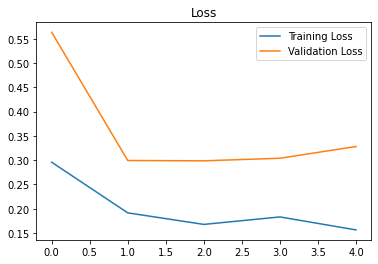

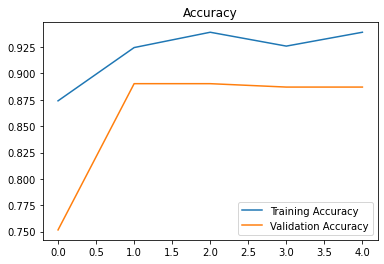

In [43]:
plot_metrics(history) 

Results



In [44]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

10/10 [==============================] - 6s 605ms/step - loss: 0.3282 - accuracy: 0.8871
Validation: accuracy = 0.887097  ;  loss_v = 0.328199
Test: accuracy = 0.841935  ;  loss = 0.369099


# Let us test our model with a sample input

In [72]:


sample = []
image = cv2.imread("/content/drive/MyDrive/brain tumor detection/Brain-Tumor-Detection-master/augmented data/no/aug_1 no._0_1102.jpg")
            # crop the brain and ignore the unnecessary rest part of the image
image = crop_brain_contour(image, plot=False)
            # resize image
image = cv2.resize(image, dsize=(240, 240), interpolation=cv2.INTER_CUBIC)
            # normalize values
image = image / 255.
            # convert image to numpy array and append it to X
sample.append(image)
sample = np.array(sample)
y=model.predict(sample)
print(y)

[[0.00831905]]


SAVE THE MODEL

In [ ]:
import json
from keras.models import model_from_json, load_model

# Save Weights + Architecture
model.save_weights('Brain_tumor_detection.h5')

with open('Brain_tumor_detection.json', 'w') as f:
    f.write(model.to_json())

# Load Weights + Architecture
with open('Brain_tumor_detection.json', 'r') as f:
    new_model = model_from_json(f.read())
new_model.load_weights('Brain_tumor_detection.h5')